In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.models import create_mixture_gaussian
from src.ksd.langevin import RandomWalkMH

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Metropolis-Adjusted Langevin dynamics

In [2]:
tf.random.set_seed(0)

In [3]:
delta = 4.
n = 500
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

2022-01-20 10:18:10.435459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 10:18:11.000449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [4]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

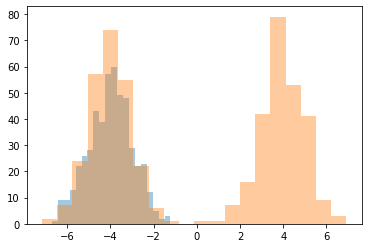

In [5]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [6]:
def log_prob_fn(x):
    exp1 = tf.reduce_sum((x - one_component_mean)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x + one_component_mean)**2, axis=-1) # n
    return tf.math.log(
        tf.math.exp(- 0.5 * exp1) + tf.math.exp(- 0.5 * exp2)
    )

mh_off = RandomWalkMH(log_prob=log_prob_fn)

In [7]:
steps = 20
std = 5.
x_init_off = tf.identity(off_samples)

mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.86it/s]


In [8]:
# check if the hard-coded log_prob equals to the built-in fn
diff = log_prob_fn(x_init_off) - proposal_on.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [9]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
            
    #         res_df = pd.DataFrame({"x": result.x.numpy()[t, :, 0], "type": "updated off-target"})
    #         res_df2 = pd.DataFrame({"x": on_samples.numpy()[:, 0], "type": "target"})
    #         res_df = pd.concat([res_df, res_df2], ignore_index=True)
    #         sns.ecdfplot(ax=col, data=res_df, hue="type", x="x", alpha=0.4)
    #         col.legend()
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

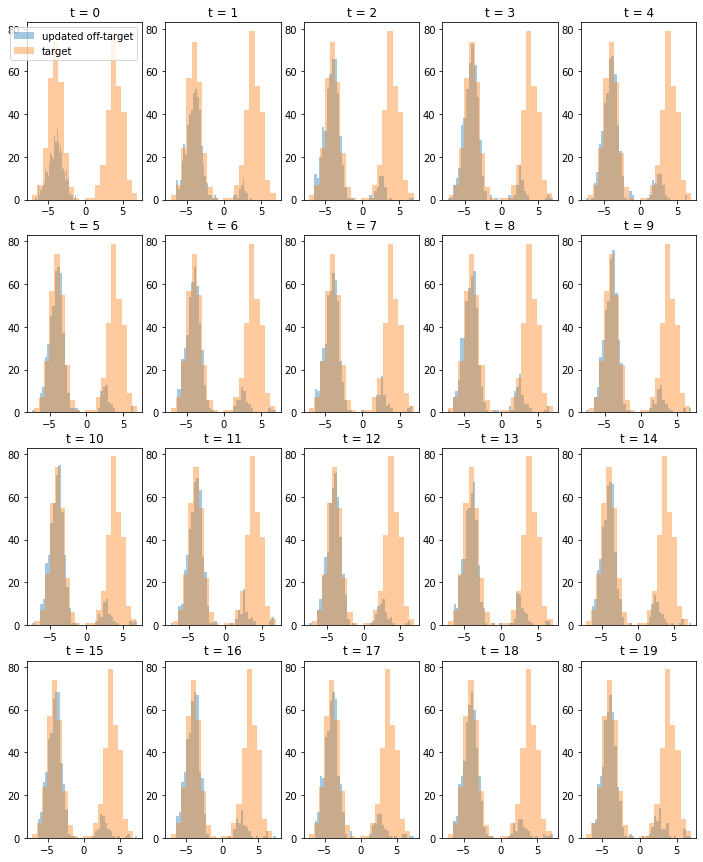

In [10]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [14]:
mh_on = RandomWalkMH(log_prob=proposal_on.log_prob)

x_init_on = tf.identity(on_samples)
mh_on.run(steps=steps, std=std, x_init=x_init_on)

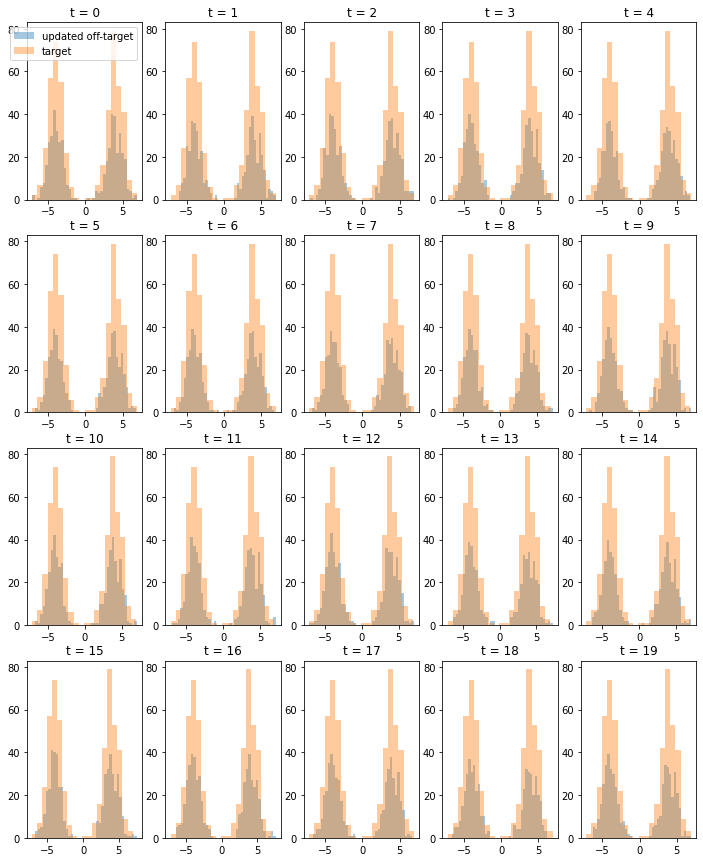

In [15]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of steps

In [24]:
tf.random.set_seed(0)

In [25]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [26]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=log_prob_fn)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=log_prob_fn)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [27]:
nsteps = 20
std = 5.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
# # ksd_df = pd.read_csv("res/mh.csv")
# ksd_df.to_csv(f"res/mh_{std}.csv", index=False)

<AxesSubplot:xlabel='t', ylabel='ksd'>

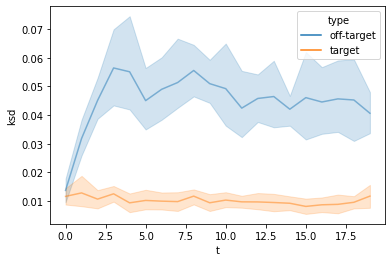

In [22]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Use BFGS to find the local modes

In [104]:
# The objective function and the gradient.
def nll_and_grad(x):
    return tfp.math.value_and_gradient(
        lambda x: -log_prob_fn(x), # minus as we want to minimise
        x)

# generate starting points
def generate_start_pts(M):
    e1 = tf.eye(dim)[:, 0]
    pts_list = [x * e1 for x in np.linspace(-8., 8., M)]
    start_pts = tf.concat([pts_list], axis=1)
    return start_pts

# compute pairwise Mahalanobis distance
def pairwise_mahalanobis(inv_hessian, x):
#     """
#     inv_hessian: dim x dim
#     x: n x dim
#     """
#     x_h = tf.expand_dims(x, axis=0) # 1 x M x dim
#     x_v = tf.expand_dims(tf.transpose(x), axis=0) # 1 x dim x M
#     res = tf.matmul(tf.matmul(x_h, inv_hessian), x_v) # M x M x M

    """
    inv_hessian: dim x dim
    x: dim
    """
    x_h = tf.expand_dims(x, axis=0) # 1 x dim
    res = x_h @ inv_hessian @ tf.transpose(x_h) # 1,
    return res[0, 0]

# merge modes according to pairwise mahalanobis distance
def merge_modes(inv_hessians, end_pts, threshold, log_prob):
    M = end_pts.shape[0]
    mode_list = [end_pts[0, :]]
    inv_hessians_list = [inv_hessians[0, :, :]]
    
    for i in range(1, M):
        maha_dist_list = []
        end_pt_i = end_pts[i, :]
        inv_hess_i = inv_hessians[i]
        
        # compute pairwise Mahalanobis dist with the existing modes
        for j in range(len(mode_list)):
            inv_hess = 0.5 * (inv_hessians_list[j] + inv_hess_i)
            diff = mode_list[j] - end_pt_i
            maha_dist = pairwise_mahalanobis(inv_hess, diff)
            maha_dist_list.append(maha_dist)
        
        # find the mode with the closest distance
        argmin_i = tf.math.argmin(maha_dist_list).numpy()
        min_maha_dist = maha_dist_list[argmin_i]
        
        if min_maha_dist < threshold:
            # classify into closest mode
            closest_mode = mode_list[argmin_i]

            if log_prob(closest_mode) < log_prob(end_pt_i):
                # if current pt is better than local mode, swap
                mode_list[argmin_i] = end_pt_i
                inv_hessians_list[argmin_i] = inv_hess_i
                
        else:
            # store current pt as a new mode
            mode_list.append(end_pt_i)
            inv_hessians_list.append(inv_hess_i)
    
    return mode_list, inv_hessians_list
    

In [56]:
M = 10 # num of starting points
start_pts = generate_start_pts(M)  # Starting point for the search.

optim_results = tfp.optimizer.bfgs_minimize(nll_and_grad, initial_position=start_pts, tolerance=1e-8)

tf.experimental.numpy.all(optim_results.converged).numpy() # should return true

True

In [62]:
end_pts = optim_results.position # M x dim
inverse_hessian_estimate = optim_results.inverse_hessian_estimate # M x dim x dim

In [105]:
threshold = 1e-3
mode_list, inv_hess_list = merge_modes(inverse_hessian_estimate, end_pts, threshold, log_prob_fn)

In [106]:
mode_list

[<tf.Tensor: shape=(5,), dtype=float32, numpy=array([-4.,  0.,  0.,  0.,  0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([4., 0., 0., 0., 0.], dtype=float32)>]

# Accept prob as a function of jump distance

In [44]:
tf.random.set_seed(0)

In [45]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

In [46]:
def jump_distance_experiment(nrep, proposal_off, proposal_on, steps, std_ls, dir_vec):
    ksd_df = pd.DataFrame(columns=["std", "ksd", "ave_accept_prob", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)

        x_init_off = off_samples
        x_init_on = on_samples

        for i, std in enumerate(std_ls):
            iterator.set_description(f"Jump dist {i+1} of {len(std_ls)}")
            
            mh_off = RandomWalkMH(log_prob=log_prob_fn)
            mh_off.run(steps=steps, std=std, x_init=x_init_off, dir_vec=dir_vec)

            mh_on = RandomWalkMH(log_prob=log_prob_fn)
            mh_on.run(steps=steps, std=std, x_init=x_init_on, dir_vec=dir_vec)

            x_t = mh_off.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ave_accept_prob_off = tf.reduce_mean(mh_off.accept_prob[-1, :]).numpy()
            ksd_df.loc[len(ksd_df)] = [std, ksd_val, ave_accept_prob_off, seed, "off-target"]
            
            x_t = mh_on.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ave_accept_prob_on = tf.reduce_mean(mh_on.accept_prob[-1, :]).numpy() 
            ksd_df.loc[len(ksd_df)] = [std, ksd_val, ave_accept_prob_on, seed, "target"]
    
    return ksd_df

In [47]:
nsteps = 20
std_ls = np.linspace(0.02, 1.5, 50).tolist()
nrep = 10
dir_vec = tf.eye(dim)[:, 0] * delta * 2

ksd_df = jump_distance_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std_ls=std_ls,
    dir_vec=dir_vec)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='std', ylabel='ave_accept_prob'>

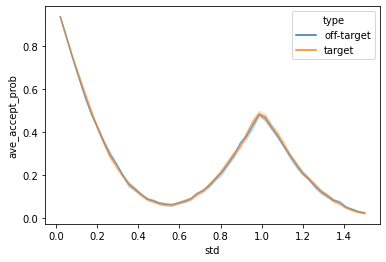

In [48]:
sns.lineplot(data=ksd_df, x="std", y="ave_accept_prob", hue="type", alpha=0.5)

<AxesSubplot:xlabel='std', ylabel='ksd'>

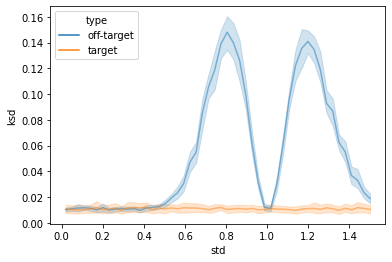

In [49]:
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type", alpha=0.5)

# Find the best discrete jump dist

In [58]:
def best_jump_distance_experiment(nrep, proposal_off, proposal_on, steps, std_ls, dir_vec):
    ksd_df = pd.DataFrame(columns=["std", "ksd", "ave_accept_prob", "seed", "type"])

    ntrain = int(n * 0.5)
    
    iterator = trange(nrep)
    for seed in iterator:
        for name, proposal in zip(["off-target", "target"], [proposal_off, proposal_on]):
            samples = proposal.sample(n)

            x_init = samples
            x_init_train, x_init_test = x_init[:ntrain, ], x_init[ntrain:, ]

            best_ksd = 0.
            for i, std in enumerate(std_ls):
                iterator.set_description(f"Jump dist {i+1} of {len(std_ls)}")

                # run dynamic
                mh = RandomWalkMH(log_prob=log_prob_fn)
                mh.run(steps=steps, std=std, x_init=x_init_train, dir_vec=dir_vec)
                
                # compute ksd
                x_t = mh.x[-1, :, :].numpy()
                ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
                
                if ksd_val > best_ksd:
                    best_std = std
                    best_ksd = ksd_val

            # run with test set
            mh = RandomWalkMH(log_prob=log_prob_fn)
            mh.run(steps=steps, std=best_std, x_init=x_init_test, dir_vec=dir_vec)

            x_t = mh.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ave_accept_prob = tf.reduce_mean(mh.accept_prob[-1, :]).numpy()
            ksd_df.loc[len(ksd_df)] = [best_std, ksd_val, ave_accept_prob, seed, name]
    
    return ksd_df

In [59]:
nsteps = 20
std_ls = np.linspace(0.02, 1., 50).tolist()
nrep = 10
dir_vec = tf.eye(dim)[:, 0] * delta * 2

ksd_df = best_jump_distance_experiment(
    nrep=nrep,
    proposal_off=proposal_off,
    proposal_on=proposal_on,
    steps=nsteps,
    std_ls=std_ls,
    dir_vec=dir_vec)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='std', ylabel='Count'>

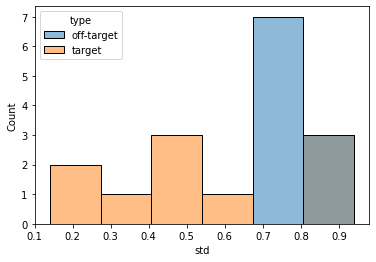

In [60]:
sns.histplot(data=ksd_df, x="std", hue="type", alpha=0.5)